In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
!pwd

/content


In [5]:
#
import zipfile
!unzip -q '/content/drive/MyDrive/Perso/projet_radio/dataset.zip'

In [6]:
import pathlib

data_dir = pathlib.Path("/content/dataset/").with_suffix('')
print (data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

/content/dataset
5380


In [7]:
COVID = list(data_dir.glob('COVID/*'))
img = PIL.Image.open(str(COVID[0]))
# print (img.mode)
#img_all = list(data_dir.glob('*/*.png'))
#for img in img_all:
#  img_read = PIL.Image.open(str(img))
#   if img_read.mode != 'L':
#    print (img, " ",img_read.mode)


In [8]:
#Define some parameters for the loader:

batch_size = 32
img_height = 256
img_width = 256

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  batch_size=batch_size,
  )

Found 5380 files belonging to 4 classes.
Using 4304 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  batch_size=batch_size,
 )

Found 5380 files belonging to 4 classes.
Using 1076 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [13]:
#normalization_layer = layers.Rescaling(1./255)
num_classes = len(class_names)

model = Sequential([
  #data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)       

In [16]:
from keras.callbacks import EarlyStopping

EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

callback = EarlyStopping(monitor='val_loss', patience=2)

In [17]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/15
135/135 [==============================] - 20s 55ms/step - loss: 0.9265 - accuracy: 0.5969 - val_loss: 0.8330 - val_accuracy: 0.6245
Epoch 2/15
135/135 [==============================] - 8s 55ms/step - loss: 0.6895 - accuracy: 0.7161 - val_loss: 0.7283 - val_accuracy: 0.6691
Epoch 3/15
135/135 [==============================] - 6s 46ms/step - loss: 0.5515 - accuracy: 0.7644 - val_loss: 0.6912 - val_accuracy: 0.7082
Epoch 4/15
135/135 [==============================] - 8s 57ms/step - loss: 0.4266 - accuracy: 0.8299 - val_loss: 0.7688 - val_accuracy: 0.7082
Epoch 5/15
135/135 [==============================] - 7s 50ms/step - loss: 0.3185 - accuracy: 0.8752 - val_loss: 0.8486 - val_accuracy: 0.7063


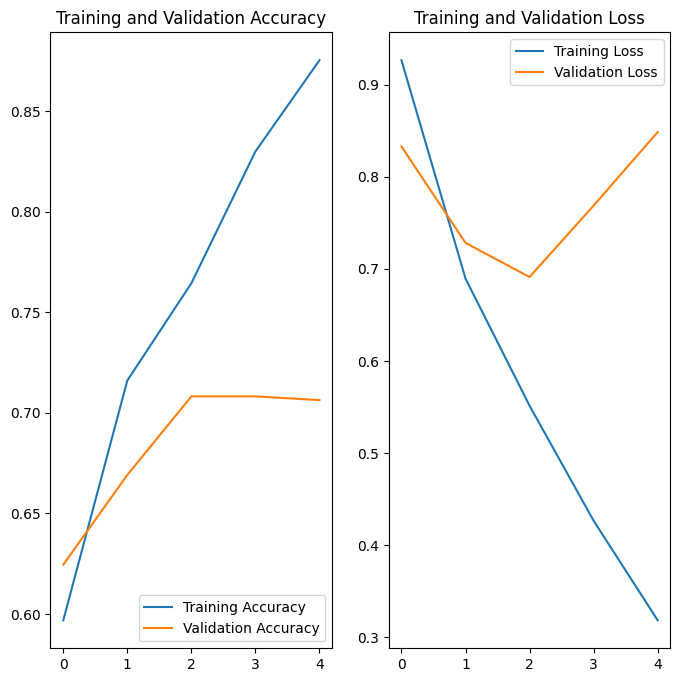

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [3]:
from sklearn.metrics import classification_report
import numpy as np

train_data = np.concatenate([x for x, y in train_ds], axis=0)
#train_data_norm = train_data / 255
train_label = np.concatenate([y for x, y in train_ds], axis=0)

val_data = np.concatenate([x for x, y in val_ds], axis=0)
#val_data_norm = val_data / 255
val_label = np.concatenate([y for x, y in val_ds], axis=0)

val_pred = model.predict(val_data)
val_pred_class = val_pred.argmax(axis = 1)
#val_class = val_label.argmax(axis = 1)

print(classification_report(val_label, val_pred_class))

NameError: ignored